<a href="https://colab.research.google.com/github/AdiY2j/CS6910_Assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00


In [2]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.set_printoptions(suppress=True)
from keras.datasets import fashion_mnist
from keras.datasets import mnist

In [3]:
wandb.login(key='72a114321dd97dbf11db7b15eb05b2660c2faa94')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Q1] Download the fashion-MNIST dataset and plot 1 sample image for each class

In [4]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
X_train.shape[0]

60000

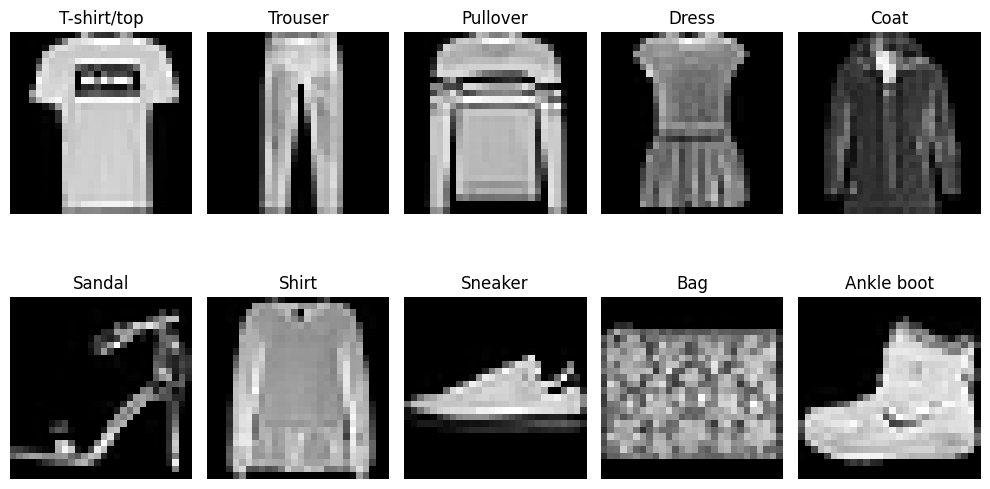

In [6]:
#wandb.init(project = 'DL_Assignment_1', entity = 'cs23m009')
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

images = []
labels = []
# Function to plot one sample image for each class
def plot_data(x, y, class_labels):
    plt.figure(figsize=(10, 6))

    for i in range(len(class_labels)):
        id = np.where(y == i)[0][0]
        image = x[id]
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.title(class_labels[i])
        images.append(image)
        labels.append(class_labels[i])

    plt.tight_layout()
    plt.show()

plot_data(X_train, y_train, class_labels)
# wandb.log({"Question 1 " : [wandb.Image(image , caption = f"Label: {label}") for image, label in zip(images, labels)]})
# wandb.finish()

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [8]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
# Reshape input feature from 28*28 to 784*1
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_val = X_val.reshape(X_val.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

In [9]:
X_train.shape

(54000, 784)

In [10]:
X_val.shape

(6000, 784)

In [11]:
def initializeParam(input_neurons, output_neurons, hidden_neurons, num_layers, activation, weight_init = "Xavier"):
  params = {}
  hidden_layer = [hidden_neurons] * num_layers
  layers = [input_neurons] + hidden_layer + [output_neurons]
  for i in range(1, len(layers)):
    if weight_init == "Xavier" or activation == "relu":
      params['W' + str(i)] = np.random.randn(layers[i], layers[i-1]) * np.sqrt(2/float(layers[i-1]))
    elif weight_init == "random":
      params['W' + str(i)] = np.random.randn(layers[i], layers[i-1])

    params['b' + str(i)] = np.zeros((layers[i], 1))
  return params

In [12]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def tanh(x):
  return np.tanh(x)

def identity(x):
  return x

def sigmoid_dev(x):
  return x * (1 - x)

def relu_dev(x):
  return np.where(x > 0, 1, 0)

def tanh_dev(x):
  return 1 - x**2

def identity_dev(x):
  return np.ones_like(x)

def softmax(x):
  x = np.clip(x, -700, 700)
  return np.exp(x) / np.sum(np.exp(x), axis = 0)

Q2] Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

In [13]:
def forward_prop(X, layers, params, activation):
  func = {}
  func['h0'] = X
  func['a0'] = X
  output = []
  for i in range(1, len(layers)):
    a = np.dot(params['W' + str(i)], func['h' + str(i-1)].T) + params['b' + str(i)]

    #print(params['W' + str(i)].shape, func['h' + str(i-1)].T.shape, params['b' + str(i)].shape, a.shape)

    if(i == len(layers) - 1) :
      h = softmax(a)
      output = h
    else :
      if activation == "sigmoid" :
        h = sigmoid(a)
      elif activation == "relu" :
        h = relu(a)
      elif activation == "tanh" :
        h = tanh(a)
      elif activation == "identity":
        h = identity(a)

    func['a' + str(i)] = a.T
    func['h' + str(i)] = h.T

  return output, func

Q3] Implement the backpropagation algorithm with support for the following optimisation functions

In [14]:
def back_prop(func, params, y, pred_y, L, loss_func, activation):
  m = y.size
  gradients = {}
  if loss_func == "cross_entropy" :
    dL_a = pred_y - y.T
  elif loss_func == "squared_loss" :
    dL_a = 2*(pred_y - y.T) * pred_y

  h_prev = func['h'+str(L)]
  act_dev = sigmoid_dev

  if activation == "sigmoid":
    act_dev = sigmoid_dev
  elif activation == "relu":
    act_dev = relu_dev
  elif activation == "tanh":
    act_dev = tanh_dev
  elif activation == "identity":
    act_dev = identity_dev

  for k in range(L, -1, -1):
    dL_W = np.dot(dL_a, h_prev)
    dL_b = np.sum(dL_a, axis=1, keepdims=True)

    #print(dL_W.shape, dL_b.shape)

    dL_h = np.dot(params['W'+str(k+1)].T,  dL_a)
    dL_a = dL_h * act_dev(h_prev).T  #sigmoid (h_prev * (1- h_prev)).T

    gradients['dW' + str(k+1)] = dL_W
    gradients['db' + str(k+1)] = dL_b
    if(k-1 > -1):
      h_prev = func['h' + str(k-1)]


  return gradients

In [15]:
def sgd(params, gradients, eta, L, decay):
  for i in range(1, L):
    params['W' + str(i)] -=  eta * (gradients['dW' + str(i)] + decay * params['W' + str(i)])
    params['b' + str(i)] -=  eta * (gradients['db' + str(i)] + decay * params['b' + str(i)])

In [16]:
def mgd(params, gradients, history, max_epochs, momentum, eta, L, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    history[key] = momentum * history[key] + eta * (gradients['d' + key] + decay * params[key])
    params[key] -= history[key]


In [17]:
def nag(params, gradients, history, max_epochs, momentum, eta, L, decay):
  for i in range(1, L):
    history['W' + str(i)] = momentum * history['W' + str(i)] + eta * (gradients['dW' + str(i)] + decay * params['W' + str(i)])
    history['b' + str(i)] = momentum * history['b' + str(i)] + eta * (gradients['db' + str(i)] + decay * params['b' + str(i)])

    params['W' + str(i)] -= history['W' + str(i)]
    params['b' + str(i)] -= history['b' + str(i)]

In [18]:
def rmsprop(params, gradients, history, max_epochs, beta, eta, eps, L, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])

  for i in range(1, L):
    history['W' + str(i)] = beta * history['W' + str(i)] + (1 - beta) * gradients['dW' + str(i)]**2
    history['b' + str(i)] = beta * history['b' + str(i)] + (1 - beta) * gradients['db' + str(i)]**2

    params['W' + str(i)] -= (eta * gradients['dW' + str(i)]/(np.sqrt(history['W' + str(i)]) + eps)) + (eta * decay * params['W' + str(i)])
    params['b' + str(i)] -= (eta * gradients['db' + str(i)]/(np.sqrt(history['b' + str(i)]) + eps)) + (eta * decay * params['b' + str(i)])

In [19]:
def adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, L, t, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    if key not in moment:
      moment[key] = np.zeros_like(params[key])

  for i in range(1, L):
    moment['W'+str(i)] = beta1 * moment['W'+str(i)] + (1-beta1) * gradients['dW'+str(i)]
    moment['b'+str(i)] = beta1 * moment['b'+str(i)] + (1-beta1) * gradients['db'+str(i)]
    history['W'+str(i)] = beta2 * history['W'+str(i)] + (1-beta2) * gradients['dW'+str(i)]**2
    history['b'+str(i)] = beta2 * history['b'+str(i)] + (1-beta2) * gradients['db'+str(i)]**2

    m_w_hat = moment['W'+str(i)]/(1 - (beta1 ** t))
    m_b_hat = moment['b'+str(i)]/(1 - (beta1 ** t))
    v_w_hat = history['W'+str(i)]/(1 - (beta2 ** t))
    v_b_hat = history['b'+str(i)]/(1 - (beta2 ** t))

    params['W'+str(i)] -= eta * m_w_hat/(np.sqrt(v_w_hat) + eps) + (eta * decay * params['W' + str(i)])
    params['b'+str(i)] -= eta * m_b_hat/(np.sqrt(v_b_hat) + eps) + (eta * decay * params['b' + str(i)])


In [20]:
def nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, L, t, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    if key not in moment:
      moment[key] = np.zeros_like(params[key])

  for i in range(1, L):
    moment['W'+str(i)] = beta1 * moment['W'+str(i)] + (1-beta1) * gradients['dW'+str(i)]
    moment['b'+str(i)] = beta1 * moment['b'+str(i)] + (1-beta1) * gradients['db'+str(i)]
    history['W'+str(i)] = beta2 * history['W'+str(i)] + (1-beta2) * gradients['dW'+str(i)]**2
    history['b'+str(i)] = beta2 * history['b'+str(i)] + (1-beta2) * gradients['db'+str(i)]**2

    m_w_hat = moment['W'+str(i)]/(1 - (beta1 ** t))
    m_b_hat = moment['b'+str(i)]/(1 - (beta1 ** t))
    v_w_hat = history['W'+str(i)]/(1 - (beta2 ** t))
    v_b_hat = history['b'+str(i)]/(1 - (beta2 ** t))

    params['W'+str(i)] -= (eta/np.sqrt(v_w_hat + eps)) * (beta1 * m_w_hat + (1-beta1) * gradients['dW'+str(i)] / (1 - beta1**t)) + (eta * decay * params['W' + str(i)])
    params['b'+str(i)] -= (eta/np.sqrt(v_b_hat + eps)) * (beta1 * m_b_hat + (1-beta1) * gradients['db'+str(i)] / (1 - beta1**t)) + (eta * decay * params['b' + str(i)])

In [21]:
def compute_loss(y, y_pred, loss, epsilon=1e-10):
  if loss == "squared_loss":
    return np.sum((y - y_pred)**2)/y.shape[0]
  elif loss == "cross_entropy":
    return -np.sum(np.multiply(y, np.log(y_pred + epsilon)))/y.shape[0]

In [22]:
def loss_dev(y, y_pred, loss):
  if loss == "cross_entropy":
    return -y/y_pred
  elif loss == "squared_loss":
    return y_pred - y

In [23]:
def get_prediction(output):
  return np.argmax(output, axis=0)

def get_accuracy(prediction, Y):
  #print(prediction, Y)
  return np.sum(prediction == Y)/Y.size

def cal_confusion(prediction, Y):
  count = 0
  confusion_mat = np.zeros((10, 10))
  for i in range(len(prediction)):
    confusion_mat[prediction[i]][Y[i]] += 1
  print(confusion_mat)

In [24]:
def lookahead(params, history, momentum):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    else :
      history[key] = momentum * history[key]
    params[key] -= history[key]

In [38]:
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'val_accuracy',
        'goal' : 'maximize'
    },
    'parameters' : {
        'epochs' : {
            'values' : [5, 10]
        },
        'batch_size' : {
            'values' : [16, 32, 64]
        },
        'learning_rate': {
            'values' : [1e-3, 5e-4, 1e-4]
        },
        'hidden_layers' : {
            'values' : [3, 4, 5]
        },
        'hidden_layer_size' :  {
            'values' : [32, 64, 128]
        },
        'weight_init' : {
            'values' : ['random', 'Xavier']
        },
        'weight_decay' : {
            'values' : [0, 0.005]
        },
        'optimizer' : {
            'values' : ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
        },
        'activation' : {
            'values' : ['sigmoid', 'relu', 'tanh']
        }
    }
}

In [39]:
sweep_id = wandb.sweep(sweep=sweep_config, project='DL_Assignment_1', entity = "cs23m009")

Create sweep with ID: w3eu1t4k
Sweep URL: https://wandb.ai/cs23m009/DL_Assignment_1/sweeps/w3eu1t4k


In [40]:
def main():
  with wandb.init() as run:
    run_name = 'o_{}_a_{}_lr_{}_hl{}_bs{}_w_{}'.format(wandb.config.optimizer, wandb.config.activation, wandb.config.learning_rate, str(wandb.config.hidden_layer_size) + "_" + str(wandb.config.hidden_layers), wandb.config.batch_size, wandb.config.weight_init)
    wandb.run.name = run_name

    params = initializeParam(784, 10, wandb.config["hidden_layer_size"], wandb.config["hidden_layers"], wandb.config["activation"], wandb.config["weight_init"])
    train(X_train, y_train, params, wandb.config["hidden_layer_size"], wandb.config["hidden_layers"], "cross_entropy", wandb.config["activation"], wandb.config["weight_init"], wandb.config["learning_rate"], wandb.config["epochs"], wandb.config["batch_size"], wandb.config["optimizer"], wandb.config["weight_decay"])

wandb.agent(sweep_id, function = main, count = 5)
wandb.finish()

wandb: Agent Starting Run: sikw4a5l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Train Loss: 1.7292581923922066, Train Accuracy: 0.4466851851851852, Val Loss: 1.72415892947413, Val Accuracy: 0.4493333333333333
Epoch 2, Train Loss: 1.3081146928423046, Train Accuracy: 0.5517407407407408, Val Loss: 1.3269920679214398, Val Accuracy: 0.5388333333333334
Epoch 3, Train Loss: 1.1774004840048349, Train Accuracy: 0.5828518518518518, Val Loss: 1.2109737309224347, Val Accuracy: 0.5653333333333334
Epoch 4, Train Loss: 1.1044518406886905, Train Accuracy: 0.600925925925926, Val Loss: 1.1424469976055376, Val Accuracy: 0.5876666666666667
Epoch 5, Train Loss: 1.0459724974454296, Train Accuracy: 0.619574074074074, Val Loss: 1.0802473550512555, Val Accuracy: 0.6086666666666667
Epoch 6, Train Loss: 1.0184944189452814, Train Accuracy: 0.6255555555555555, Val Loss: 1.0501043884358487, Val Accuracy: 0.6095
Epoch 7, Train Loss: 0.9800354717260751, Train Accuracy: 0.6396481481481482, Val Loss: 1.0267658276302347, Val Accuracy: 0.628
Epoch 8, Train Loss: 0.9561539524296608, Train Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.65867
train_loss,0.91271
val_accuracy,0.644
val_loss,0.96832


wandb: Agent Starting Run: 44xsdh8s with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.4693575243652115, Train Accuracy: 0.8378888888888889, Val Loss: 0.48218712104274014, Val Accuracy: 0.834
Epoch 2, Train Loss: 0.4340525577195519, Train Accuracy: 0.8493518518518518, Val Loss: 0.44695754309727365, Val Accuracy: 0.8441666666666666
Epoch 3, Train Loss: 0.4152013230650425, Train Accuracy: 0.8548888888888889, Val Loss: 0.42978302379875016, Val Accuracy: 0.8493333333333334
Epoch 4, Train Loss: 0.4008018462075178, Train Accuracy: 0.8605, Val Loss: 0.4167831167641025, Val Accuracy: 0.8518333333333333
Epoch 5, Train Loss: 0.3895540188007915, Train Accuracy: 0.864537037037037, Val Loss: 0.4073326807198129, Val Accuracy: 0.8553333333333333
Epoch 6, Train Loss: 0.3812953161068527, Train Accuracy: 0.8666111111111111, Val Loss: 0.4010763981344313, Val Accuracy: 0.8566666666666667
Epoch 7, Train Loss: 0.3736879514967151, Train Accuracy: 0.868537037037037, Val Loss: 0.3960883089219428, Val Accuracy: 0.8606666666666667
Epoch 8, Train Loss: 0.3673474414887674, Tra

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.87494
train_loss,0.35575
val_accuracy,0.86633
val_loss,0.38409


wandb: Agent Starting Run: 2m4m4wt8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.005
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.4287071637654129, Train Accuracy: 0.8471481481481481, Val Loss: 0.44309033850720203, Val Accuracy: 0.8396666666666667
Epoch 2, Train Loss: 0.3817116744685554, Train Accuracy: 0.8607037037037037, Val Loss: 0.4047671680855597, Val Accuracy: 0.8493333333333334
Epoch 3, Train Loss: 0.3475078040341816, Train Accuracy: 0.8732962962962963, Val Loss: 0.3794479148845807, Val Accuracy: 0.8605
Epoch 4, Train Loss: 0.3217681727203214, Train Accuracy: 0.882, Val Loss: 0.3600708964670829, Val Accuracy: 0.8681666666666666
Epoch 5, Train Loss: 0.30741518411747815, Train Accuracy: 0.8873148148148148, Val Loss: 0.35469884053188755, Val Accuracy: 0.8718333333333333


epoch,▁▃▅▆█
train_accuracy,▁▃▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▃▆▇█
val_loss,█▅▃▁▁
epoch,5
train_accuracy,0.88731
train_loss,0.30742
val_accuracy,0.87183
val_loss,0.3547


wandb: Agent Starting Run: 5ds73qa3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Train Loss: 0.47138530485710844, Train Accuracy: 0.8292777777777778, Val Loss: 0.47813167360921316, Val Accuracy: 0.828
Epoch 2, Train Loss: 0.4016184348586847, Train Accuracy: 0.8522037037037037, Val Loss: 0.4110585252792477, Val Accuracy: 0.8518333333333333
Epoch 3, Train Loss: 0.36888609065567746, Train Accuracy: 0.8652407407407408, Val Loss: 0.3843981658657697, Val Accuracy: 0.8575
Epoch 4, Train Loss: 0.36002254736249495, Train Accuracy: 0.8669444444444444, Val Loss: 0.38117843248115824, Val Accuracy: 0.8616666666666667
Epoch 5, Train Loss: 0.3395342546328681, Train Accuracy: 0.8758148148148148, Val Loss: 0.3662080061722645, Val Accuracy: 0.8706666666666667


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.87581
train_loss,0.33953
val_accuracy,0.87067
val_loss,0.36621


wandb: Agent Starting Run: edscuf2c with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Train Loss: 0.4234805333725031, Train Accuracy: 0.8453148148148149, Val Loss: 0.44205498301788826, Val Accuracy: 0.836
Epoch 2, Train Loss: 0.36292379796863505, Train Accuracy: 0.8672037037037037, Val Loss: 0.38640740163990606, Val Accuracy: 0.8603333333333333
Epoch 3, Train Loss: 0.34378827383897803, Train Accuracy: 0.8745, Val Loss: 0.37703055634029353, Val Accuracy: 0.8636666666666667
Epoch 4, Train Loss: 0.3108285966239497, Train Accuracy: 0.8845925925925926, Val Loss: 0.34682037949472383, Val Accuracy: 0.8738333333333334
Epoch 5, Train Loss: 0.29807134548468556, Train Accuracy: 0.8887777777777778, Val Loss: 0.3448623554536425, Val Accuracy: 0.8763333333333333


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▅▄▂▁
val_accuracy,▁▅▆██
val_loss,█▄▃▁▁
epoch,5
train_accuracy,0.88878
train_loss,0.29807
val_accuracy,0.87633
val_loss,0.34486


In [34]:
def train(X_train, y_train, params, hidden_layer_size, no_layers, loss_func, activation_func, wt_init, learning_rate, epochs, batch_size, optimizer, weight_decay):
  input_neurons = X_train.shape[1]
  hidden_neurons = hidden_layer_size #wandb.config["hidden_layer_size"]
  num_layers = no_layers #wandb.config["hidden_layers"]
  hidden_layer = [hidden_neurons] * num_layers
  output_neurons = 10
  layers = [input_neurons] + hidden_layer + [output_neurons]
  y_train_onehot = np.eye(10)[y_train]
  y_val_onehot = np.eye(10)[y_val]
  loss_function = loss_func #"cross_entropy"
  activation = activation_func #wandb.config["activation"]
  weight_init = wt_init #wandb.config["weight_init"]

  eta = learning_rate #wandb.config["learning_rate"]
  max_epochs = epochs #wandb.config["epochs"]
  momentum = 0.5
  beta = 0.9
  beta1 = 0.9
  beta2 = 0.999
  eps = 0.000001
  batch_size= batch_size #wandb.config["batch_size"]
  optimizer = optimizer #wandb.config["optimizer"]
  decay = weight_decay #wandb.config["weight_decay"]
  final_res = []
  history = {}
  moment = {}

  for epoch in range(max_epochs):
    for i in range(0, X_train.shape[0], batch_size):
      X_batch = X_train[i : i + batch_size]
      y_batch = y_train_onehot[i : i + batch_size]

      output, func = forward_prop(X_batch, layers, params, activation)
      if(optimizer == "nesterov"):
        lookahead(params, history, momentum)
      gradients = back_prop(func, params, y_batch, output, len(hidden_layer), loss_function, activation)
      match optimizer:
        case "sgd":
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)
        case "momentum":
          mgd(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "nesterov":
          nag(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "rmsprop":
          rmsprop(params, gradients, history, max_epochs, beta, eta, eps, len(hidden_layer)+2, decay)
        case "adam":
          adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case "nadam":
          nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case default:
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)

    y_predict, func = forward_prop(X_train, layers, params, activation)
    train_loss = compute_loss(y_train_onehot, y_predict.T, loss_function)
    train_accuracy = get_accuracy(get_prediction(y_predict), y_train)

    y_val_predict, _ = forward_prop(X_val, layers, params, activation)
    val_loss = compute_loss(y_val_onehot, y_val_predict.T, loss_function)
    val_accuracy = get_accuracy(get_prediction(y_val_predict), y_val)

    #final_res = get_prediction(y_predict)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
    wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'val_loss' : val_loss, 'val_accuracy' : val_accuracy, 'epoch': epoch+1})

Q7] For the best model identified above, report the accuracy on the test set of fashion_mnist and plot the confusion matrix

In [27]:
def confusion_matrix(X_test, y_test, params, hidden_layer_size, hidden_layers, loss_func, activation_func, wt_init, learning_rate, epochs, batch, opt_func, wt_decay):
  #wandb.init(project = 'DL_Assignment_1', entity = 'cs23m009')
  input_neurons = X_test.shape[1]
  hidden_neurons = hidden_layer_size
  num_layers = hidden_layers
  hidden_layer = [hidden_neurons] * num_layers
  output_neurons = 10
  layers = [input_neurons] + hidden_layer + [output_neurons]
  y_test_onehot = np.eye(10)[y_test]
  loss_function = loss_func
  activation = activation_func
  weight_init = wt_init

  eta = learning_rate
  max_epochs = epochs
  momentum = 0.5
  beta = 0.9
  beta1 = 0.9
  beta2 = 0.999
  eps = 0.000001
  batch_size= batch
  optimizer = opt_func
  decay = wt_decay
  final_res = []
  history = {}
  moment = {}

  y_predict, func = forward_prop(X_test, layers, params, activation)
  test_loss = compute_loss(y_test_onehot, y_predict.T, loss_function)
  test_accuracy = get_accuracy(get_prediction(y_predict), y_test)
  cal_confusion(get_prediction(y_predict), y_test)
  #wandb.log({"Confusion Matrix " : wandb.sklearn.plot_confusion_matrix(y_test, get_prediction(y_predict), class_labels)})
  print(test_accuracy, test_loss)
  #wandb.finish()

In [ ]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
params = initializeParam(784, 10, 128, 5, "tanh", "Xavier")
train(X_train, y_train, params, 128, 5, "cross_entropy", "tanh", "Xavier", 0.001, 10, 64, "nadam", 0)
confusion_matrix(X_test, y_test, params, 128, 5, "cross_entropy", "tanh", "Xavier", 0.001, 10, 64, "nadam", 0)
wandb.finish()

wandb: Currently logged in as: cs23m009. Use `wandb login --relogin` to force relogin


Epoch 1, Train Loss: 0.3648646409662875, Train Accuracy: 0.8677407407407407, Val Loss: 0.3817300908910881, Val Accuracy: 0.8626666666666667
Epoch 2, Train Loss: 0.31303790748881766, Train Accuracy: 0.886462962962963, Val Loss: 0.3421380934391721, Val Accuracy: 0.8763333333333333
Epoch 3, Train Loss: 0.2897950677801674, Train Accuracy: 0.8937777777777778, Val Loss: 0.3284180461942331, Val Accuracy: 0.8803333333333333
Epoch 4, Train Loss: 0.27399062998494533, Train Accuracy: 0.8988888888888888, Val Loss: 0.3209283509487721, Val Accuracy: 0.882
Epoch 5, Train Loss: 0.2612766689397047, Train Accuracy: 0.9031296296296296, Val Loss: 0.31604947580374837, Val Accuracy: 0.8846666666666667
Epoch 6, Train Loss: 0.25056403628469825, Train Accuracy: 0.9069259259259259, Val Loss: 0.31307029381347423, Val Accuracy: 0.8866666666666667
Epoch 7, Train Loss: 0.241315965259485, Train Accuracy: 0.9097777777777778, Val Loss: 0.3113697326123061, Val Accuracy: 0.888
Epoch 8, Train Loss: 0.23310537930530584, T

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▅▆▆▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.91819
train_loss,0.21872
val_accuracy,0.88833
val_loss,0.3101


Q8]  Compare the cross entropy loss with the squared error loss.

In [ ]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
params = initializeParam(784, 10, 128, 5, "relu", "Xavier")
train(X_train, y_train, params, 128, 5, "cross_entropy", "relu", "Xavier", 0.001, 10, 64, "nadam", 0)
wandb.finish()

Epoch 1, Train Loss: 0.3773927223207784, Train Accuracy: 0.8635, Val Loss: 0.39640582693975085, Val Accuracy: 0.8548333333333333
Epoch 2, Train Loss: 0.3279305768257256, Train Accuracy: 0.8807037037037037, Val Loss: 0.3565593932815739, Val Accuracy: 0.8676666666666667
Epoch 3, Train Loss: 0.29605565612699636, Train Accuracy: 0.8916666666666667, Val Loss: 0.33584534911510977, Val Accuracy: 0.8776666666666667
Epoch 4, Train Loss: 0.27940966667141043, Train Accuracy: 0.8963518518518518, Val Loss: 0.32938951267795286, Val Accuracy: 0.8811666666666667
Epoch 5, Train Loss: 0.26463771532420866, Train Accuracy: 0.9012777777777777, Val Loss: 0.32354735718822886, Val Accuracy: 0.8833333333333333
Epoch 6, Train Loss: 0.25458757423838896, Train Accuracy: 0.9048888888888889, Val Loss: 0.3215091310994867, Val Accuracy: 0.8858333333333334
Epoch 7, Train Loss: 0.24631469997777627, Train Accuracy: 0.9083703703703704, Val Loss: 0.3216345652018047, Val Accuracy: 0.8885
Epoch 8, Train Loss: 0.236692388297

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.91702
train_loss,0.22198
val_accuracy,0.89183
val_loss,0.3213


In [ ]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
params = initializeParam(784, 10, 128, 5, "relu", "Xavier")
train(X_train, y_train, params, 128, 5, "squared_loss", "relu", "Xavier", 0.001, 10, 64, "nadam", 0)
wandb.finish()

Epoch 1, Train Loss: 0.20476974134232306, Train Accuracy: 0.8553148148148149, Val Loss: 0.2125454142244745, Val Accuracy: 0.8538333333333333
Epoch 2, Train Loss: 0.18042121337176592, Train Accuracy: 0.8722962962962963, Val Loss: 0.1944323914001503, Val Accuracy: 0.8661666666666666
Epoch 3, Train Loss: 0.16902932668018983, Train Accuracy: 0.8809814814814815, Val Loss: 0.18654533779306362, Val Accuracy: 0.8706666666666667
Epoch 4, Train Loss: 0.16172208083602246, Train Accuracy: 0.8853518518518518, Val Loss: 0.18230900901332306, Val Accuracy: 0.876
Epoch 5, Train Loss: 0.1564134431527494, Train Accuracy: 0.8898333333333334, Val Loss: 0.17861391288136458, Val Accuracy: 0.8788333333333334
Epoch 6, Train Loss: 0.15337384193856363, Train Accuracy: 0.8917962962962963, Val Loss: 0.1771242863359013, Val Accuracy: 0.8821666666666667
Epoch 7, Train Loss: 0.15156660797748053, Train Accuracy: 0.8934074074074074, Val Loss: 0.17595239401138812, Val Accuracy: 0.8815
Epoch 8, Train Loss: 0.150259060188

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.89552
train_loss,0.14772
val_accuracy,0.8815
val_loss,0.17522


Q10] Check for MNIST Data (before running make sure to load data above)

In [ ]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
params = initializeParam(784, 10, 128, 3, "tanh", "Xavier")
train(X_train, y_train, params, 128, 3, "cross_entropy", "tanh", "Xavier", 0.001, 5, 64, "nadam", 0)
wandb.finish()

Epoch 1, Train Loss: 0.13913660528434196, Train Accuracy: 0.9592222222222222, Val Loss: 0.14960237242350102, Val Accuracy: 0.9556666666666667
Epoch 2, Train Loss: 0.10207545687837169, Train Accuracy: 0.9698148148148148, Val Loss: 0.11769313776955816, Val Accuracy: 0.9631666666666666
Epoch 3, Train Loss: 0.08269739214398683, Train Accuracy: 0.9761296296296297, Val Loss: 0.10252944526447023, Val Accuracy: 0.9683333333333334
Epoch 4, Train Loss: 0.06946561901210568, Train Accuracy: 0.9802407407407407, Val Loss: 0.09290916322233164, Val Accuracy: 0.971
Epoch 5, Train Loss: 0.05931154060477616, Train Accuracy: 0.9836481481481482, Val Loss: 0.08600659430422498, Val Accuracy: 0.9723333333333334


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.98365
train_loss,0.05931
val_accuracy,0.97233
val_loss,0.08601


In [ ]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
params = initializeParam(784, 10, 128, 3, "relu", "Xavier")
train(X_train, y_train, params, 128, 3, "cross_entropy", "relu", "Xavier", 0.001, 5, 32, "adam", 0)
wandb.finish()

Epoch 1, Train Loss: 0.11564349013781504, Train Accuracy: 0.9659814814814814, Val Loss: 0.12631628541584256, Val Accuracy: 0.9623333333333334
Epoch 2, Train Loss: 0.07829164263362623, Train Accuracy: 0.9771481481481481, Val Loss: 0.0978412427170717, Val Accuracy: 0.971
Epoch 3, Train Loss: 0.05945462958211382, Train Accuracy: 0.9824074074074074, Val Loss: 0.0849233621992687, Val Accuracy: 0.975
Epoch 4, Train Loss: 0.046879566584988264, Train Accuracy: 0.9860740740740741, Val Loss: 0.07811875925435342, Val Accuracy: 0.976
Epoch 5, Train Loss: 0.037607983256658116, Train Accuracy: 0.9892592592592593, Val Loss: 0.07401636429229443, Val Accuracy: 0.9781666666666666


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.98926
train_loss,0.03761
val_accuracy,0.97817
val_loss,0.07402


In [ ]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
params = initializeParam(784, 10, 128, 3, "sigmoid", "Xavier")
train(X_train, y_train, params, 128, 3, "cross_entropy", "sigmoid", "Xavier", 0.005, 5, 32, "adam", 0)
wandb.finish()

Epoch 1, Train Loss: 0.1288975356131402, Train Accuracy: 0.9616851851851852, Val Loss: 0.13919352968291185, Val Accuracy: 0.9581666666666667
Epoch 2, Train Loss: 0.0847039110022841, Train Accuracy: 0.9737777777777777, Val Loss: 0.10691753311448292, Val Accuracy: 0.9671666666666666
Epoch 3, Train Loss: 0.0606462128171564, Train Accuracy: 0.9807592592592592, Val Loss: 0.09271760355784689, Val Accuracy: 0.9718333333333333
Epoch 4, Train Loss: 0.04558094505726645, Train Accuracy: 0.9860185185185185, Val Loss: 0.08627647669602516, Val Accuracy: 0.9743333333333334
Epoch 5, Train Loss: 0.03533986651503786, Train Accuracy: 0.9890925925925926, Val Loss: 0.08389776886727046, Val Accuracy: 0.9773333333333334


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.98909
train_loss,0.03534
val_accuracy,0.97733
val_loss,0.0839
